In [ ]:
 pip install torchtext

In [ ]:
pip install pandas

In [ ]:
pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 50.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.16.0-py3-none-any.whl size=30813255 sha256=e608735a7940027e6d290d04bfce03ebb8a0a76d50bb74e194f1fa3a5df1fd8c
  Stored in directory: /root/.cache/pip/wheels/6b/03/2b/ac2c97cc65ebd9df3516f4b900adc2f0a744df8d1375b2e2ef
Successfully built kiwipiepy-model


In [ ]:
import pickle

In [ ]:
######################
# 모듈 임포트
######################
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable
from torchtext.vocab import build_vocab_from_iterator

from tqdm import tqdm

#import spacy

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import time

tqdm.pandas()

In [ ]:
from kiwipiepy import Kiwi #사용할 형태소분석기

In [ ]:
import re

In [ ]:
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#데이터 위치한 경로 및 모델 저장 경로
DATA_PATH = "/content/drive/MyDrive/ml/MiniProj/Datas"
MODEL_PATH = "/content/drive/MyDrive/ml"

In [ ]:
def extract_zip_file(zip_filename, extract_path):
    # ZIP 파일 압축 해제
    with zipfile.ZipFile(DATA_PATH+zip_filename, 'r') as zipf:
        zipf.extractall(extract_path)

    # 압축 해제된 CSV 파일을 데이터프레임으로 읽기
    csv_filename = f"{extract_path}/comp_review_final.csv"

    dataframe = pd.read_csv(csv_filename,encoding='utf-8')
    return dataframe

In [ ]:
zip_file_name = '/comp_review_final.zip'
extract_path = DATA_PATH

# ZIP 파일 압축 해제하여 데이터프레임 가져오기
review_cont_df = extract_zip_file(zip_file_name, extract_path)

In [ ]:
review_cont_df.head(1)

,review_uid,comp_uid,review_cont,review_senti_orig,review_senti_pred,review_rate,is_office,review_date,position,create_date,modify_date
0,1,1,"1. 명절 복지가 뛰어납니다: 인턴인데 집에 한우가 와서, 집에서 당황했을 정도입니...",P,NaN,5,1,202109,데이터,20230831,20230831


In [ ]:
senti_to_int = []
for sent in review_cont_df['review_senti_orig']:
  if sent == 'P':
    sent = 1
    senti_to_int.append(sent)
  else:
    sent = 0
    senti_to_int.append(sent)

In [ ]:
review_cont_df['review_senti_orig']=senti_to_int

In [ ]:
review_cont_df['review_senti_orig'].value_counts()

1    221146
0    221144
Name: review_senti_orig, dtype: int64

In [ ]:
review_cont_df.tail(2)

,review_uid,comp_uid,review_cont,review_senti_orig,review_senti_pred,review_rate,is_office,review_date,position,create_date,modify_date
442288,442289,1000,"역동적이고 진취적인 일을 하고자 한다면 만족스럽지 못할 수도 있고, 고위직 간부들은...",0,NaN,4,1,201502,기획/경영,20230831,20230831
442289,442290,1000,주인이 없음. 총장이 3년마다 바뀌고 정부에 따라서도 정책과 내용이 바뀜. 윗자리에...,0,NaN,2,0,201409,기타,20230831,20230831


In [ ]:
#--------------------------------------------------------------------------

In [ ]:
review_cont_df = review_cont_df[['review_cont','review_senti_orig']]

In [ ]:
review_cont_df

,review_cont,review_senti_orig
0,"1. 명절 복지가 뛰어납니다: 인턴인데 집에 한우가 와서, 집에서 당황했을 정도입니...",1
1,온보딩을 기초로 입사부터 체계적으로 회사에 적응할 수 있는 환경을 만들어 줍니다! ...,1
2,"똑똑한 팀원들, 수평적인 업무 분위기, 도움이 필요할 때 손을 내미면 다들 적극적으...",1
3,"스타트업이라 회사 성장과 목표, 액션플랜을 구체화하는 단계에서 구성원들이 많은 제안...",1
4,수평적이고 자유로운 분위기. 나날이 좋아지는 복지와 지원. 성장하기 좋은 환경.,1
...,...,...
442285,팀에 따라 다르나 비교적 자유로운 분위기. 젊은 사람이 많아 또래문화 경험. 젊은이...,1
442286,비합리적 인사평가. 비전문인력이 정규직이고 전문인력은 비정규직임. 괜찮은 관리자가 없음.,0
442287,고용노동부가 주요 사업파트너 입니다. 계약직에게 비전이 없습니다.,0
442288,"역동적이고 진취적인 일을 하고자 한다면 만족스럽지 못할 수도 있고, 고위직 간부들은...",0


In [ ]:
######################
# 전처리 클래스 정의 utils.py에 넣어줌
######################
class ReviewDataPreprocessing():
    def __init__(self, df, state_dict = None):
        # spacy 객체 생성 (자연어 전처리 모델)
        #self.nlp = spacy.load("en_core_web_sm")

        #한국어 형태소분석기
        self.kiwi =Kiwi()

        if state_dict == None:
          # vocab 생성
          print('set vocab')
          self.vocab = self.__set_vocab(df)
        else :
          # 기존 vocab 불러오기
          print('set vocab from state_dict')
          self.vocab =self.__open_vocab_dict(df,state_dict)
        # features 전처리 및 토큰화(feature,review), 패딩
        print('set features')
        self.features = self.__featurs_processing(df)
        # targets 전처리(긍정 부정 라벨링)
        print('set targets')
        self.targets = self.__targets_processing(df)

    def load_data(self):
        #데이터 로딩 리뷰와 타겟 불러옴
          return self.features, self.targets
    """def load_saved_vocab(self):
          #사전에 저장된 보캡을 불러옴
          return self.saved_vocab"""

    def load_vocab(self):
        #vocab 로더
        return self.vocab

    # vocab 생성 함수 정의
    def __set_vocab(self, df):
        # iterator 생성
        token_gen = self.__yield_tokens(df,
                                        self.__pretreatment_and_tokenizer,
                                        )
        # vocab 생성
        vocab = build_vocab_from_iterator(token_gen,  # iterator
                                        specials=["<pad>","<unk>"], # 특수 토큰
                                        )
        # unkonwn 토큰의 인덱스를 0으로 설정
        vocab.set_default_index(vocab["<unk>"])
        # vocab 반환
        return vocab
    def __open_vocab_dict(self,df,state_dict): #df랑 token_gen 추가
        #경로 받아서 이미 저장된 보캡 로드

         with open(MODEL_PATH + state_dict, 'rb') as f:
            vocab = pickle.load(f)
         token_gen = self.__yield_tokens(df,
                    self.__pretreatment_and_tokenizer,
                    )
         #vocab = {token: index for token, index in vocab if isinstance(token, str)}
         return vocab
    # 피처 전처리 함수 정의(리뷰들) #progress_map이 뭘까
    def __featurs_processing(self, df):
        print('indexing') #리뷰들을 받아서 인덱싱
        data = df['review_cont'].progress_map(self.__tokens_to_index)
        print('padding') #리뷰들 길이 맞추는 패딩 작업
        features = self.__padding(data)
        return np.array(features)
        #리뷰 받으면 인덱싱하고 패딩하는 함수

    # 타겟 전처리 함수 정의
    def __targets_processing(self, df):
        # 타겟 데이터만 추출 컬럼이름에 맞게 가져오기

        targets = df['review_senti_orig']
        #targets = targets.reset_index(drop=True) #인덱스 재정렬 인덱스 뒤죽박죽으로 들어가는 경우가 있어서 나중에 필요없다 하면 빼고
        targets = targets.to_numpy().astype(int)
        # positive를 1, negative를 0으로 변환 후 numpy array로 변환 이것도 긍정 부정 컬럼명 맞춰서 바꿔서 넣어주기
        #targets = (targets=='positive').to_numpy().astype(int)
        return targets

    # iterator 정의
    def __yield_tokens(self, data, tokenizer):
        #토크나이저와 데이터를 불러옴
        print('tokenizing')
        data['review_cont'] = data['review_cont'].progress_map(tokenizer)

        print('build vocab')
        for token in tqdm(data['review_cont']):
            yield token
            #리뷰 하나하나 토큰화

    # 인덱싱 함수 정의
    def __tokens_to_index(self, tokens): # 토큰화한 리뷰들을 인덱싱
        return [self.vocab[token] for token in tokens]

    # 전처리 및 토큰화 함수 정의
    def __pretreatment_and_tokenizer(self, text):
        # 공백 제거
        try:
          #text = text.strip()
          #특수문자 제거
          #text = text.replace('.','')
          pattern = r'[^가-힣\s]'  # 알파벳, 한글, 공백을 제외한 모든 문자
          text = re.sub(pattern, '', text)

          # <br /> 태그 제거
          #text = text.replace('<br />', '') #html 줄바꿈 제거 코드 혹시모르니 넣어둠
        except:
          text = str(text) #text가 str로 인식되지 않는경우

          pattern = r'[^가-힣\s]'  # 알파벳, 한글, 공백을 제외한 모든 문자
          text = re.sub(pattern, '', text)
          #text = text.strip()
          # <br /> 태그 제거
          #text = text.replace('<br />', '') #html 줄바꿈 제거 코드 혹시모르니 넣어둠



        # 소문자로 변환
        #text = text.lower()






        # 형태소 분석기를 통한 토큰화
        #doc = self.kiwi(text)
        # 명사, 동사, 형용사만 토큰화
        doc = self.kiwi.tokenize(text)
        #print(type(doc))

        return [token.form for token in doc]#[token.form for token in doc if token.tag.find('NNP') != -1 or token.tag.find('NNG') != -1 or token.tag.find('VV') != -1 or token.tag.find('VA') != -1 or token.tag.find('MAG') != -1 or token.tag.find('IC') != -1   ]#[token.form for token in doc]

    # 패딩 함수 정의
    def __padding(self, features):
        # 최대 길이 계산
        max_len = max(len(feature) for feature in features)
        print(max_len)
        padding_features = []
        for feature in tqdm(features):
            # 패딩 토큰화된리뷰보다 긴 길이는 패딩화
            padding_feature = feature + [0] * (max_len - len(feature))
            # 패딩된 데이터를 리스트에 저장
            padding_features.append(padding_feature)
        return padding_features

In [ ]:
######################
# 데이터셋 정의 utils.py에 넣어줌
######################
class ReviewDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.int64)
        if self.y is not None:
            y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X, y

In [ ]:
######################
# 레이어 클래스 정의
######################
# 임베딩 레이어 클래스 정의
class EmbeddingLayer(nn.Module):
    def __init__(self, n_class, embedding_size=128):
        super().__init__()
        #n_class는 VOCAB의 개수임 임베딩레이어에서의 아웃풋사이즈가 임베딩사이즈 입력데이터를 고정된 차원(여기서는 128)의 벡터로 표현
        self.emb_layer = nn.Embedding(n_class,    # n_class
                                    embedding_size, # output_size = embedding_size
                                    )

    def forward(self, X):
        return self.emb_layer(X)
# LSTM 레이어 클래스 정의
class LSTMLayer(nn.Module):
    def __init__(self, embedding_size=128, hidden_size=128, num_layers=3, is_bidirectional=True):
       #임베딩사이즈는 위에 설명한대로고 히든사이즈는 LSTM등의 순차적 모델에서 입력 시퀸스를 처리하고 중간상태를 생성하는데 사용하는 노드수
        super().__init__()
        # 변수 저장
        self.shape_size = (2 if is_bidirectional else 1) * num_layers
        self.hidden_size = hidden_size

        self.lstm_layer = nn.LSTM(input_size=embedding_size, # input_size = embedding_size
                                hidden_size=hidden_size,    # 은닉층의 갯수
                                num_layers=num_layers,      # 은닉층 각각의 레이어 갯수
                                bidirectional=is_bidirectional,  # 양방향 LSTM 여부
                                )

    def forward(self, X):
        # 축교환
        _X = X.transpose(0, 1)
        # hidden_state의 마지막 값만 반환 (순차적으로 히든 스테이트에서 마지막 값이 output이고 그 과정은 중간저장 cell 이니까)
        output_raw = self.__get_hidden_state(_X, len(X)) #여기서 마지막 히든스테이트만 가져옴
        return output_raw

    def __get_hidden_state(self, X, lenght):
        # hidden_state와 cell_state의 shape 정의
        shape = (self.shape_size, lenght, self.hidden_size)
        # hidden_state와 cell_state를 초기화
        hidden_state = torch.zeros(shape).to(X.device)
        cell_state = torch.zeros(shape).to(X.device)
        # LSTM 레이어를 통해 output과 hidden_state, cell_state를 반환
        _, (hidden_state, __) = self.lstm_layer(X, (hidden_state, cell_state))
        return hidden_state[-1]
# 이진 출력 레이어 클래스 정의
class BinaryOutputLayer(nn.Module):
    def __init__(self, input_size=128):
        super().__init__()
        self.output_layer = nn.Sequential(
            # 데이터의 양을 반으로 줄임
            nn.Linear(input_size, input_size//2, bias=False),
            # 활성화 함수
            nn.ReLU(),
            # 출력 데이터의 양을 1로 줄임
            nn.Linear(input_size//2, 1, bias=False),
            # 이진분류 이므로 시그모이드 함수를 통해 0~1사이의 값으로 변환
            nn.Sigmoid(),
            )

    def forward(self, X):
        return self.output_layer(X)

In [ ]:
######################
# 얼리 스토핑 클래스 정의
######################
class EarlyStopping():
    def __init__(self, patience=10, save_path=None, target_score=0):
        # 초기화
        self.best_score = 0
        self.patience_count = 0
        self.target_score = target_score
        self.patience = patience
        self.save_path = save_path
        self.datetime = time.strftime
    # 얼리 스토핑 여부 확인 함수 정의
    def is_stop(self, model, score, epoch):
        # 모델 저장(마지막 모델)
        self.__save_last_model(model)
        # 스코어가 타겟 스코어보다 낮을 경우
        if score < self.target_score:
            # patience 초기화
            self.patience_count = 0
            return False

        # 스코어가 이전보다 좋을 경우
        if self.best_score < score:
            # 스코어를 업데이트
            self.best_score = score
            # 모델 저장
            self.__save_model(model, epoch)
            # patience 초기화
            self.patience_count = 0
            return False

        # 스코어가 이전보다 좋지 않을 경우 +
        # 스코어가 타겟 스코어보다 높을 경우
        # patience 증가
        self.patience_count += 1
        # patience가 최대치를 넘을 경우
        if self.patience_count > self.patience:
            return True
        # patience가 최대치를 넘지 않을 경우
        return False
    # 모델 저장 함수 정의
    def __save_model(self, model, epoch):
        model_name = f'/comp_review_model_{self.datetime("%m%d_%H%M")}_{epoch+1:04d}.pth'
        torch.save(model.state_dict(), self.save_path + model_name)
    # 마지막 모델 저장 함수 정의
    def __save_last_model(self, model):
        model_name = f'/comp_review_model_last.pth'
        torch.save(model.state_dict(), self.save_path + model_name)

In [ ]:
######################
# 모델 정의
######################
class CompReviewPNModel(nn.Module):
    def __init__(self, n_class, embedding_size=128, hidden_size=128, num_layers=3, is_bidirectional=True):
        super().__init__()
        self.seq = nn.Sequential(
            # 임베딩 레이어
            EmbeddingLayer(n_class=n_class,
                        embedding_size=embedding_size,
                        ),
            # LSTM 레이어
            LSTMLayer(embedding_size=embedding_size,
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        is_bidirectional=is_bidirectional,
                        ),
            # 이진 아웃풋 레이어
            BinaryOutputLayer(
                        input_size=hidden_size
                        ),
        )

    def forward(self, X):
        return self.seq(X)

In [ ]:
######################
# 학습 함수 정의
######################
def train_loop(dataloader, model, loss_fn, optimizer, device, threshold=0.5):
    # 손실값 초기화
    loss_list = []
    score_list = []
    # 모델을 학습 모드로 설정
    model.train()
    # 배치 단위로 학습
    for X, y in dataloader:
        # 데이터를 디바이스에 할당
        X = X.to(device)
        y = y.reshape(-1,1).to(device)
        # 모델을 통해 예측
        pred = model(X)
        # pred값 클래스로 변환
        pred_class = (pred > threshold).to(torch.int64)
        # 손실값 계산
        loss = loss_fn(pred, y)
        # 기울기 초기화
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 가중치 업데이트
        optimizer.step()
        # 손실값을 리스트에 저장
        loss_list.append(loss.item())
        # 정확도를 리스트에 저장
        score_list.append(accuracy_score(pred_class.cpu().detach().numpy(),
                                        y.cpu().numpy(),
                                        ))
    # 손실값 평균 계산
    loss_mean = np.mean(loss_list)
    # 정확도 평균 계산
    score_mean = np.mean(score_list)
    # 손실값 평균, 정확도 평균 반환
    return loss_mean, score_mean

######################
# 평가 함수 정의
######################
@torch.inference_mode()
def test_loop(dataloader, model, device, threshold=0.5):
    # 저장값 초기화
    score_list = []
    pred_list = [] #예측값 모아놓은 리스트 나중에 해보기
    # 모델을 평가 모드로 설정
    model.eval()
    # 배치 단위로 평가
    for X, y in dataloader:
        # 데이터를 디바이스에 할당
        X = X.to(device)
        #일단 index비교는 상관없을것 같긴한데 혹시모르니 넣어두기
        #y_train_reset =y_train.reset_index(drop=True)
        #y_train_array = y_train_reset.to_numpy() #나중에 위에 데이터 전처리에 올려 이부분 인덱싱 순서대로하고 ndarray 형태로 바꿔줌
        #y= y.reset_index(drop=True)

        y = y.reshape(-1,1).to(device)
        # 모델을 통해 예측
        pred = model(X)

        # 예측값을 클래스로 변환 0.5가 넘으면 긍정?
        pred_class = (pred > threshold).to(torch.int64)
        for val in pred_class:
            if val.item() == 1:
                pred_list.append('P')
            else:
                pred_list.append('N')
        pred_list.append(pred_class)

        # 정확도를 리스트에 저장
        score_list.append(accuracy_score(pred_class.cpu().detach().numpy(),
                                        y.cpu().numpy(),
                                        ))
    # 정확도 평균 계산
    score_mean = np.mean(score_list)
    #pred_list 마지막 이상한거 제거
    pred_list = pred_list[:-1]
    # 정확도 평균 반환
    return score_mean,pred_list

######################
# epoch 학습 함수 정의
######################
def epoch_loop(train_dataloader, valid_dataloader, model, loss_fn, optimizer, device, threshold=0.5):
    # 학습
    train_loss, train_score = train_loop(train_dataloader, model, loss_fn, optimizer, device, threshold)
    # 평가
    valid_score = test_loop(valid_dataloader, model, device, threshold)[0] #이거 [0] 아니면 바로 수정
    # 손실값 평균, 정확도 평균 반환
    return train_loss, train_score, valid_score

In [ ]:
######################
# 객체 및 변수 생성
######################
#각각 features,targets가 데이터와 라벨들 그리고 vocab이 어휘집
# 데이터 전처리 객체 생성
preprocessing_module = ReviewDataPreprocessing(review_cont_df) #경로를 원하는 경로로 바꿔주면 됨
# 데이터 로드
features, targets = preprocessing_module.load_data()

# vocab 로드
vocab = preprocessing_module.load_vocab()



set vocab
tokenizing


100%|██████████| 442290/442290 [14:13<00:00, 518.42it/s]


build vocab


100%|██████████| 442290/442290 [00:02<00:00, 200718.60it/s]


set features
indexing


100%|██████████| 442290/442290 [00:11<00:00, 37986.18it/s]


padding
554


100%|██████████| 442290/442290 [00:06<00:00, 69913.92it/s]


set targets


In [ ]:
"""import pickle

# Vocab 객체 저장
save_path = "/MiniProj/Models/voab_442290_final2.pkl"
with open(MODEL_PATH + save_path, 'wb') as f:
    pickle.dump(vocab, f)"""



In [ ]:
"""# Vocab 객체 로드
load_path = "/MiniProj/Models/voab.pkl"
with open(MODEL_PATH + load_path, 'rb') as f:
    vocab_loaded = pickle.load(f)"""

In [ ]:
######################
# 데이터셋 나누기
######################
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    targets,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1473032201,
                                                    stratify=targets,
                                                    )

In [ ]:
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((353832, 554), (88458, 554), (353832,), (88458,))

In [ ]:
######################
# 상수 정의
######################
# 단어(클래스) 갯수
N_CLASS = len(vocab)

# 에폭 수
N_EPOCHS = 100
# 배치 크기
BATCH_SIZE = 1000
# 임베딩 차원 수 (임베딩된 단어의 벡터 차원 수)
EMBEDDING_SIZE = 128
# LSTM 레이어 은닉층의 차원 수
HIDDEN_SIZE = 10
# LSTM 레이어 은닉층 각각의 레이어 갯수
NUM_LAYERS = 3
# LSTM 레이어 양방향 여부
IS_BIDIRECTIONAL = True
# 학습률
LR = 0.001
# 얼리 스토핑 횟수
PATIENCE = 10
# 얼리 스토핑 타겟 스코어
TARGET_SCORE = 0.75
# 쓰레시 홀드(이진분류 기준)
#THRES_HOLD = 0.5
THRES_HOLD = 0.5
# 디바이스 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CPU = 'cpu'

# 얼리 스토핑 객체 생성
early_stopping = EarlyStopping(patience=PATIENCE,
                            save_path=MODEL_PATH,
                            target_score=TARGET_SCORE,
                            )

# 모델 객체 생성
model = CompReviewPNModel(n_class=N_CLASS,
                        embedding_size=EMBEDDING_SIZE,
                        hidden_size=HIDDEN_SIZE,
                        num_layers=NUM_LAYERS,
                        is_bidirectional=IS_BIDIRECTIONAL,
                        ).to(DEVICE)

# 손실함수 객체 생성
loss_fn = torch.nn.BCELoss()

# optimizer 객체 생성
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# K-Fold 객체 생성
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True, random_state=1473032201)

In [ ]:
######################
# 학습
######################
# 전체 손실값 및 정확도 저장 딕셔너리
loss_score_dict = {
    'train_loss':[],
    'train_score':[],
    'valid_score':[],
}
# 에폭 수 만큼 학습
for epoch in tqdm(range(N_EPOCHS)):
    # 손실값 및 정확도 초기화
    train_loss_list = []
    train_score_list = []
    valid_score_list = []
    # K-Fold를 통한 학습 및 평가
    for i, (tri, vai) in enumerate(cv.split(X_train)):
        # 데이터셋 생성
        #print(y_train[tri])
        #y_train_reset =y_train.reset_index(drop=True)
        #y_train_array = y_train_reset.to_numpy() #나중에 위에 데이터 전처리에 올려 이부분 인덱싱 순서대로하고 ndarray 형태로 바꿔줌
        train_dataset = ReviewDataset(X_train[tri], y_train[tri])#_array[tri])

        valid_dataset = ReviewDataset(X_train[vai], y_train[vai])#_array[vai])
        # 데이터로더 생성
        train_dataloader = DataLoader(train_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    drop_last=True,
                                    )
        valid_dataloader = DataLoader(valid_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    )
        # epoch 학습
        loss_and_scores = epoch_loop(train_dataloader,
                                    valid_dataloader,
                                    model,
                                    loss_fn,
                                    optimizer,
                                    DEVICE,
                                    THRES_HOLD,
                                    )
        train_loss, train_score, valid_score = loss_and_scores
        print(f"train_loss: {train_loss}, train_score: {train_score}, valid_score: {valid_score}")
        #if valid
        # 손실값 및 정확도 저장
        train_loss_list.append(train_loss)
        train_score_list.append(train_score)
        valid_score_list.append(valid_score)
    #valid_score_list.shape
    # epoch 손실값 및 정확도 계산
    train_loss_mean = np.mean(train_loss_list)
    train_score_mean = np.mean(train_score_list)
    valid_score_mean = np.mean(valid_score_list)
    #train_loss += loss 하고
    #trian_loss /= len(train_dataset) #이런식으로 하면 안돼??
    # epoch 손실값 및 정확도 저장
    loss_score_dict['train_loss'].append(train_loss_mean)
    loss_score_dict['train_score'].append(train_score_mean)
    loss_score_dict['valid_score'].append(valid_score_mean)
    # 얼리 스토핑
    if early_stopping.is_stop(model, valid_score_mean, epoch):

        print(f'Early Stopping at {epoch+1} epoch')
        break

  0%|          | 0/100 [00:00<?, ?it/s]

train_loss: 0.4105429522456213, train_score: 0.8467844522968198, valid_score: 0.9123219971720807
train_loss: 0.18625486686878406, train_score: 0.9307844522968199, valid_score: 0.9333519474080468
train_loss: 0.150085047308632, train_score: 0.9443144876325088, valid_score: 0.9478267201117936
train_loss: 0.13032338397031118, train_score: 0.9513498233215547, valid_score: 0.9547410362961056


  1%|          | 1/100 [02:57<4:52:58, 177.56s/it]

train_loss: 0.11637912661679642, train_score: 0.9569575971731448, valid_score: 0.961166697311808
train_loss: 0.10516805338670003, train_score: 0.9611307420494699, valid_score: 0.9643407091833923
train_loss: 0.09556928961521324, train_score: 0.9655053003533569, valid_score: 0.9671900582110657
train_loss: 0.0878247770714465, train_score: 0.9684275618374556, valid_score: 0.96990846909131
train_loss: 0.08079605499552332, train_score: 0.9711378091872791, valid_score: 0.9720688780200787


  2%|▏         | 2/100 [05:55<4:50:17, 177.73s/it]

train_loss: 0.07478227637471242, train_score: 0.9734028268551235, valid_score: 0.9768509542897067
train_loss: 0.0680594315140281, train_score: 0.9763215547703179, valid_score: 0.9736518170299502
train_loss: 0.06338836332987138, train_score: 0.9781413427561836, valid_score: 0.9789242337991442
train_loss: 0.058785217271150214, train_score: 0.9799293286219081, valid_score: 0.9805606589931231
train_loss: 0.05492735266448542, train_score: 0.9814982332155477, valid_score: 0.9828270878534913


  3%|▎         | 3/100 [08:52<4:46:55, 177.48s/it]

train_loss: 0.05322384722399206, train_score: 0.9823816254416962, valid_score: 0.9842906998124517
train_loss: 0.04690541881844138, train_score: 0.9845936395759717, valid_score: 0.9849584626402481
train_loss: 0.0434153244860286, train_score: 0.9861554770318021, valid_score: 0.9858880401050371
train_loss: 0.04201121399896515, train_score: 0.9866537102473498, valid_score: 0.9850285735299525
train_loss: 0.03958225718538142, train_score: 0.9875441696113075, valid_score: 0.9874542345456551


  4%|▍         | 4/100 [11:51<4:44:59, 178.12s/it]

train_loss: 0.03729387609347332, train_score: 0.9884770318021201, valid_score: 0.989908064575442
train_loss: 0.03497981617733994, train_score: 0.989268551236749, valid_score: 0.9898176175698256
train_loss: 0.03220315990712849, train_score: 0.9904840989399292, valid_score: 0.9892670731035494
train_loss: 0.030617476023022783, train_score: 0.9909363957597174, valid_score: 0.9917781782076269
train_loss: 0.02907942190384591, train_score: 0.9914911660777385, valid_score: 0.9921964108410254


  5%|▌         | 5/100 [14:50<4:42:11, 178.22s/it]

train_loss: 0.027395415605233436, train_score: 0.9922402826855122, valid_score: 0.9931518037730299
train_loss: 0.025601165982904472, train_score: 0.9927809187279152, valid_score: 0.9925279027489576
train_loss: 0.024145898815613017, train_score: 0.9933109540636044, valid_score: 0.9932939934260057
train_loss: 0.02368032855768244, train_score: 0.9935901060070671, valid_score: 0.9928572058985768
train_loss: 0.022975848699745463, train_score: 0.9937385159010599, valid_score: 0.9936611995734197


  6%|▌         | 6/100 [17:50<4:40:20, 178.94s/it]

train_loss: 0.02158607405037767, train_score: 0.9942650176678444, valid_score: 0.9944757474350019
train_loss: 0.02060825783469757, train_score: 0.9944734982332156, valid_score: 0.9929051545255889
train_loss: 0.020000521021207314, train_score: 0.9947738515901059, valid_score: 0.9948714582147383
train_loss: 0.01887818276075903, train_score: 0.9951696113074204, valid_score: 0.9958376420402308
train_loss: 0.018294771347530582, train_score: 0.995356890459364, valid_score: 0.995771522082889


  7%|▋         | 7/100 [20:51<4:38:13, 179.50s/it]

train_loss: 0.018067433994079122, train_score: 0.9953356890459366, valid_score: 0.995212444379068
train_loss: 0.017540949673224043, train_score: 0.9955971731448764, valid_score: 0.9958083441981748
train_loss: 0.01678159246764182, train_score: 0.9956996466431096, valid_score: 0.995813871494941
train_loss: 0.016077557496410586, train_score: 0.9960812720848057, valid_score: 0.9965547751259514
train_loss: 0.015240603365175189, train_score: 0.9964204946996466, valid_score: 0.9965039164490861


  8%|▊         | 8/100 [23:50<4:35:07, 179.42s/it]

train_loss: 0.015093575870164081, train_score: 0.9963533568904595, valid_score: 0.9968689368587502
train_loss: 0.014784157239953747, train_score: 0.9964028268551236, valid_score: 0.9943178838349525
train_loss: 0.014697592533539073, train_score: 0.9964063604240283, valid_score: 0.99630682924142
train_loss: 0.014522394705925782, train_score: 0.9965159010600707, valid_score: 0.9968928032949657
train_loss: 0.013603952005768834, train_score: 0.996922261484099, valid_score: 0.9967433530688046


  9%|▉         | 9/100 [26:49<4:32:09, 179.44s/it]

train_loss: 0.014314256044098113, train_score: 0.9965583038869258, valid_score: 0.9964420990696135
train_loss: 0.01234018829710413, train_score: 0.9972084805653709, valid_score: 0.9968322346071211
train_loss: 0.012703109421115698, train_score: 0.9969858657243816, valid_score: 0.9973674458747269
train_loss: 0.0123872696245155, train_score: 0.9971660777385158, valid_score: 0.997082558011253
train_loss: 0.012636926931381727, train_score: 0.9970671378091871, valid_score: 0.9971322399146839


 10%|█         | 10/100 [29:50<4:29:31, 179.69s/it]

train_loss: 0.012360609795111676, train_score: 0.9971802120141343, valid_score: 0.9972730849851064
train_loss: 0.012624973648428496, train_score: 0.9969787985865723, valid_score: 0.9972406853113466
train_loss: 0.011648463409858041, train_score: 0.9973144876325089, valid_score: 0.997588519382265
train_loss: 0.011232701572836392, train_score: 0.9975088339222613, valid_score: 0.9979448387452652
train_loss: 0.01067528896841678, train_score: 0.9977102473498233, valid_score: 0.9975688596329937


 11%|█         | 11/100 [32:49<4:26:37, 179.75s/it]

train_loss: 0.011494156097427221, train_score: 0.9973710247349822, valid_score: 0.9977660427315854
train_loss: 0.011575657729957872, train_score: 0.9972190812720847, valid_score: 0.9976436087188059
train_loss: 0.010278869022092001, train_score: 0.9976572438162544, valid_score: 0.997259048423527
train_loss: 0.010123809046554626, train_score: 0.9978268551236749, valid_score: 0.9981040709005993
train_loss: 0.010230712999027, train_score: 0.997773851590106, valid_score: 0.9980759018865148


 12%|█▏        | 12/100 [35:48<4:23:03, 179.36s/it]

train_loss: 0.010305420061377578, train_score: 0.9976537102473498, valid_score: 0.9974280145625712
train_loss: 0.009633716133706166, train_score: 0.9977667844522968, valid_score: 0.996588519382265
train_loss: 0.008992066071697844, train_score: 0.9981766784452296, valid_score: 0.9974519529169802
train_loss: 0.009259867219027303, train_score: 0.9979611307420495, valid_score: 0.9980520354502994
train_loss: 0.009209037069790723, train_score: 0.9980247349823322, valid_score: 0.9983771558857057


 13%|█▎        | 13/100 [38:47<4:20:09, 179.42s/it]

train_loss: 0.00959259345625649, train_score: 0.9978586572438163, valid_score: 0.9980985915492959
train_loss: 0.00871479347539085, train_score: 0.9979999999999999, valid_score: 0.9979730796775437
train_loss: 0.009282361676129957, train_score: 0.9978056537102474, valid_score: 0.998268854325431
train_loss: 0.008496690797989747, train_score: 0.9982155477031802, valid_score: 0.9978462471959695
train_loss: 0.008815905412448432, train_score: 0.9981201413427561, valid_score: 0.9984702680836978


 14%|█▍        | 14/100 [41:47<4:17:11, 179.44s/it]

train_loss: 0.008317740000998304, train_score: 0.9982614840989399, valid_score: 0.9983575920273601
train_loss: 0.00825005619994006, train_score: 0.9980636042402827, valid_score: 0.9981280092550084
train_loss: 0.0085377992092148, train_score: 0.9980777385159009, valid_score: 0.9979351047615549
train_loss: 0.008298571882588467, train_score: 0.9981024734982331, valid_score: 0.9981744934358104
train_loss: 0.008143789063959773, train_score: 0.9982120141342757, valid_score: 0.9983012539991908


 15%|█▌        | 15/100 [44:48<4:14:47, 179.86s/it]

train_loss: 0.008167706585658694, train_score: 0.9981802120141343, valid_score: 0.9985309086897363
train_loss: 0.00746128260768463, train_score: 0.9983498233215549, valid_score: 0.9980336963108508
train_loss: 0.00811007534389881, train_score: 0.9980989399293286, valid_score: 0.9984335898048
train_loss: 0.007239259402440407, train_score: 0.9985229681978799, valid_score: 0.998573162210863
train_loss: 0.007649016768964461, train_score: 0.9982897526501765, valid_score: 0.9984604861545251


 16%|█▌        | 16/100 [47:47<4:11:43, 179.81s/it]

train_loss: 0.006776994309806044, train_score: 0.9986219081272085, valid_score: 0.9986576692531166
train_loss: 0.006843940690143343, train_score: 0.9985053003533569, valid_score: 0.9981463723671887
train_loss: 0.006965894913736915, train_score: 0.998547703180212, valid_score: 0.9980814771287438
train_loss: 0.007564405475244545, train_score: 0.9982826855123675, valid_score: 0.9976154157319899
train_loss: 0.00707471426415945, train_score: 0.9984381625441696, valid_score: 0.9970575148016033


 17%|█▋        | 17/100 [50:46<4:08:15, 179.47s/it]

train_loss: 0.0074302549768064845, train_score: 0.9983003533568905, valid_score: 0.9984929577464788
train_loss: 0.006050334397379256, train_score: 0.998720848056537, valid_score: 0.9983392768606423
train_loss: 0.006510880192747511, train_score: 0.9985300353356891, valid_score: 0.9989252988596508
train_loss: 0.006825446843107103, train_score: 0.9984204946996467, valid_score: 0.9986533666752472
train_loss: 0.006120225556347809, train_score: 0.99873851590106, valid_score: 0.9985504725480819


 18%|█▊        | 18/100 [53:46<4:05:16, 179.47s/it]

train_loss: 0.005924806568126586, train_score: 0.9987243816254417, valid_score: 0.9990520354502995
train_loss: 0.0071060421075277, train_score: 0.9983074204946997, valid_score: 0.9982774115357067
train_loss: 0.006068773574669691, train_score: 0.9986784452296819, valid_score: 0.9987801751840903
train_loss: 0.0058496935262637665, train_score: 0.9987561837455832, valid_score: 0.9986111131541207
train_loss: 0.006514565881988356, train_score: 0.9985300353356891, valid_score: 0.9984745706615674


 19%|█▉        | 19/100 [56:45<4:02:14, 179.43s/it]

train_loss: 0.006076780633874198, train_score: 0.9986395759717315, valid_score: 0.9989816129150881
train_loss: 0.005097676762511342, train_score: 0.9989787985865722, valid_score: 0.9986350515085296
train_loss: 0.00577021903661162, train_score: 0.9987667844522966, valid_score: 0.998897129845566
train_loss: 0.005918284098604569, train_score: 0.9987137809187278, valid_score: 0.9988125988305815
train_loss: 0.0057996603339012095, train_score: 0.9987455830388692, valid_score: 0.998854852351708


 20%|██        | 20/100 [59:43<3:58:41, 179.01s/it]

train_loss: 0.005548996933326191, train_score: 0.9988197879858657, valid_score: 0.9982773875629757
train_loss: 0.005679386057652362, train_score: 0.998643109540636, valid_score: 0.9986576932258475
train_loss: 0.005890247532760547, train_score: 0.9986325088339221, valid_score: 0.9985689075784564
train_loss: 0.0055705708731911985, train_score: 0.9987314487632507, valid_score: 0.9986999227742434
train_loss: 0.005601075265429875, train_score: 0.9988021201413427, valid_score: 0.9974984370977825


 21%|██        | 21/100 [1:02:42<3:55:51, 179.14s/it]

train_loss: 0.005173816977380594, train_score: 0.9988904593639575, valid_score: 0.9989956974221309
train_loss: 0.005335468840114805, train_score: 0.9987491166077739, valid_score: 0.998277411535707
train_loss: 0.005109643114421372, train_score: 0.9989575971731448, valid_score: 0.9989393833666927
train_loss: 0.004535105008863952, train_score: 0.9990954063604239, valid_score: 0.9983012539991908
train_loss: 0.005689172489056858, train_score: 0.9987279151943462, valid_score: 0.998953443901004


 22%|██▏       | 22/100 [1:05:41<3:52:44, 179.03s/it]

train_loss: 0.005140069541200509, train_score: 0.9988798586572438, valid_score: 0.9988407678446659
train_loss: 0.004497668890993345, train_score: 0.9990388692579504, valid_score: 0.9990098059019039
train_loss: 0.0050874134454079786, train_score: 0.9988409893992933, valid_score: 0.9987422002681015
train_loss: 0.005721528071156529, train_score: 0.9986325088339223, valid_score: 0.9986858382672013
train_loss: 0.004896588514615739, train_score: 0.9989505300353356, valid_score: 0.9989913948442612


 23%|██▎       | 23/100 [1:08:41<3:49:55, 179.16s/it]

train_loss: 0.0046446384371928015, train_score: 0.9989787985865722, valid_score: 0.9988689368587503
train_loss: 0.004869085272968263, train_score: 0.9988939929328622, valid_score: 0.9989491892685972
train_loss: 0.004580045029868178, train_score: 0.9989964664310954, valid_score: 0.9990943129441576
train_loss: 0.004353654859139166, train_score: 0.9990706713780918, valid_score: 0.9989350568160922
train_loss: 0.004730741699393214, train_score: 0.998964664310954, valid_score: 0.9990802044643842


 24%|██▍       | 24/100 [1:11:39<3:46:45, 179.02s/it]

train_loss: 0.004773531147865447, train_score: 0.9989328621908129, valid_score: 0.9986154157319898
train_loss: 0.004781502564338961, train_score: 0.9989187279151944, valid_score: 0.9987464788732394
train_loss: 0.005043735921830466, train_score: 0.9988233215547704, valid_score: 0.9992590484235269
train_loss: 0.004038676261953687, train_score: 0.9991484098939928, valid_score: 0.9991506269995953
train_loss: 0.004106527512157566, train_score: 0.9991413427561839, valid_score: 0.9991463244217262


 25%|██▌       | 25/100 [1:14:39<3:44:06, 179.29s/it]

train_loss: 0.004429008753710285, train_score: 0.9990106007067137, valid_score: 0.9984984370977824
train_loss: 0.004282224889023578, train_score: 0.9990141342756184, valid_score: 0.9990563380281687
train_loss: 0.005043496943902481, train_score: 0.9987879858657244, valid_score: 0.998949189268597
train_loss: 0.00391350108885384, train_score: 0.999208480565371, valid_score: 0.9989956974221307
train_loss: 0.0038867306263291345, train_score: 0.999155477031802, valid_score: 0.9987519582245432


 26%|██▌       | 26/100 [1:17:37<3:40:41, 178.94s/it]

train_loss: 0.004268709269566988, train_score: 0.9990282685512368, valid_score: 0.9990422535211267
train_loss: 0.004235802378234793, train_score: 0.998982332155477, valid_score: 0.9990098059019041
train_loss: 0.0042851821059943585, train_score: 0.9989752650176678, valid_score: 0.9989816368878195
train_loss: 0.00377834471076926, train_score: 0.9992155477031803, valid_score: 0.9991322399146837
train_loss: 0.004413829128095031, train_score: 0.9989187279151942, valid_score: 0.9993478100981871


 27%|██▋       | 27/100 [1:20:36<3:37:45, 178.98s/it]

train_loss: 0.0038089560720799723, train_score: 0.9991625441696113, valid_score: 0.9993380281690137
train_loss: 0.003384947220427922, train_score: 0.9992155477031801, valid_score: 0.9988689608314816
train_loss: 0.004221090173300244, train_score: 0.9989363957597172, valid_score: 0.9990098059019041
train_loss: 0.004371345780445131, train_score: 0.9990212014134274, valid_score: 0.9989068878020078
train_loss: 0.0038091003509771485, train_score: 0.9991448763250885, valid_score: 0.9989534439010039


 28%|██▊       | 28/100 [1:23:35<3:34:33, 178.81s/it]

train_loss: 0.0036330326926580204, train_score: 0.9991731448763249, valid_score: 0.9993337255911448
train_loss: 0.004059027523625487, train_score: 0.9989717314487631, valid_score: 0.9989351047615549
train_loss: 0.0036527381181184616, train_score: 0.9991766784452295, valid_score: 0.9991929044934533
train_loss: 0.003437801985240413, train_score: 0.9993038869257951, valid_score: 0.9991928805207222
train_loss: 0.003920642704060779, train_score: 0.9991201413427561, valid_score: 0.9992210495348068


 29%|██▉       | 29/100 [1:26:35<3:32:07, 179.27s/it]

train_loss: 0.0033540181323430127, train_score: 0.9992544169611307, valid_score: 0.9989956974221307
train_loss: 0.0035626226252988935, train_score: 0.9991342756183748, valid_score: 0.9991690140845071
train_loss: 0.0034620846725458136, train_score: 0.9991590106007067, valid_score: 0.9988787667333858
train_loss: 0.0033482592146680773, train_score: 0.9992402826855122, valid_score: 0.999089986393557
train_loss: 0.0037692849582526833, train_score: 0.9991166077738516, valid_score: 0.9991365424925529


 30%|███       | 30/100 [1:29:34<3:28:56, 179.09s/it]

train_loss: 0.0037252279516809717, train_score: 0.999077738515901, valid_score: 0.9993618946052292
train_loss: 0.0031237833881351683, train_score: 0.9992579505300352, valid_score: 0.9991886258883155
train_loss: 0.003042842663547712, train_score: 0.9993286219081272, valid_score: 0.9988646822263437
train_loss: 0.0039567421541126385, train_score: 0.9990035335689045, valid_score: 0.9991322399146839
train_loss: 0.0034471593814998265, train_score: 0.9991872791519434, valid_score: 0.9976490640973781


 31%|███       | 31/100 [1:32:33<3:26:02, 179.17s/it]

train_loss: 0.0036643135902108197, train_score: 0.9990883392226148, valid_score: 0.9991224579855109
train_loss: 0.0028715098694060658, train_score: 0.9993038869257951, valid_score: 0.9993521126760563
train_loss: 0.002826477002349185, train_score: 0.9993992932862192, valid_score: 0.9992774115357068
train_loss: 0.0034068110230804157, train_score: 0.9992049469964663, valid_score: 0.9990238664362153
train_loss: 0.0031557139967709727, train_score: 0.9992473498233216, valid_score: 0.9993337255911448


 32%|███▏      | 32/100 [1:35:33<3:23:22, 179.45s/it]

train_loss: 0.0031818897788254085, train_score: 0.9992544169611307, valid_score: 0.999323943661972
train_loss: 0.003164980313929897, train_score: 0.9991590106007069, valid_score: 0.9990520594230307
train_loss: 0.0031607261503155608, train_score: 0.9992226148409895, valid_score: 0.9991886258883157
train_loss: 0.0028148078418899552, train_score: 0.9993427561837455, valid_score: 0.9991647115066377
train_loss: 0.0031217311961142767, train_score: 0.9992049469964663, valid_score: 0.9993196410841024


 33%|███▎      | 33/100 [1:38:33<3:20:34, 179.62s/it]

train_loss: 0.003316790353882788, train_score: 0.9990883392226149, valid_score: 0.999291472070018
train_loss: 0.0025872128942916366, train_score: 0.9993533568904593, valid_score: 0.9992069890004956
train_loss: 0.00267706292078957, train_score: 0.9993604240282684, valid_score: 0.999338028169014
train_loss: 0.002563821423608339, train_score: 0.9993533568904592, valid_score: 0.9994041481263559
train_loss: 0.00258715189279155, train_score: 0.9993462897526499, valid_score: 0.9994041481263559


 34%|███▍      | 34/100 [1:41:32<3:17:22, 179.43s/it]

train_loss: 0.0032709658367731263, train_score: 0.9991766784452296, valid_score: 0.9993153385062331
train_loss: 0.0027240776033601445, train_score: 0.9992367491166078, valid_score: 0.9990140845070421
train_loss: 0.0028602910535463523, train_score: 0.9992332155477031, valid_score: 0.9992492425216224
train_loss: 0.002582699108209425, train_score: 0.9993356890459364, valid_score: 0.9991701908579412
train_loss: 0.0029066929039064065, train_score: 0.9992897526501766, valid_score: 0.9993478100981871


 35%|███▌      | 35/100 [1:44:32<3:14:28, 179.52s/it]

train_loss: 0.0024788208885238483, train_score: 0.9993674911660778, valid_score: 0.9994182326333985
train_loss: 0.0027389079055711034, train_score: 0.9992155477031803, valid_score: 0.9992774115357068
train_loss: 0.0023641191268575874, train_score: 0.9993674911660778, valid_score: 0.9992535211267604
train_loss: 0.002715475285568113, train_score: 0.9992826855123675, valid_score: 0.9993759791122717
train_loss: 0.002633003622831122, train_score: 0.9992897526501766, valid_score: 0.9995027396756516


 36%|███▌      | 36/100 [1:47:33<3:11:52, 179.88s/it]

train_loss: 0.002946165200880673, train_score: 0.9991802120141344, valid_score: 0.9994041481263561
train_loss: 0.0023929572815582314, train_score: 0.9993144876325087, valid_score: 0.9992676056338027
train_loss: 0.0020502972108932694, train_score: 0.9994628975265019, valid_score: 0.9993576399728223
train_loss: 0.001954729528727451, train_score: 0.999469964664311, valid_score: 0.9994886551686096
train_loss: 0.0017210521054627536, train_score: 0.9995830388692579, valid_score: 0.9993055565770601


 37%|███▋      | 37/100 [1:50:34<3:09:10, 180.17s/it]

train_loss: 0.0026062208576133647, train_score: 0.9992296819787987, valid_score: 0.9993478100981869
train_loss: 0.00252437335079085, train_score: 0.9992720848056537, valid_score: 0.998957746478873
train_loss: 0.002752718213883306, train_score: 0.9992332155477033, valid_score: 0.999394366197183
train_loss: 0.0022353824873783137, train_score: 0.9993851590106008, valid_score: 0.999428014562571
train_loss: 0.0023052051347730164, train_score: 0.9993286219081272, valid_score: 0.9994886551686095


 38%|███▊      | 38/100 [1:53:34<3:06:17, 180.28s/it]

train_loss: 0.001980283469059003, train_score: 0.9994946996466431, valid_score: 0.9996295002390321
train_loss: 0.0017053111673173554, train_score: 0.9995265017667844, valid_score: 0.9994366197183098
train_loss: 0.002175418390988499, train_score: 0.9993568904593639, valid_score: 0.9994647887323944
train_loss: 0.0019949789360515667, train_score: 0.9994346289752651, valid_score: 0.9994182326333982
train_loss: 0.0024352915015922326, train_score: 0.9993003533568904, valid_score: 0.9995731622108628


 39%|███▉      | 39/100 [1:56:37<3:04:10, 181.16s/it]

train_loss: 0.001951297519476788, train_score: 0.9994805653710246, valid_score: 0.9991408450704224
train_loss: 0.002140722297431898, train_score: 0.9993286219081272, valid_score: 0.999338028169014
train_loss: 0.002246182953312338, train_score: 0.999339222614841, valid_score: 0.9994041720990869
train_loss: 0.001527271394727072, train_score: 0.9996007067137809, valid_score: 0.9994886551686093
train_loss: 0.0016719254918526874, train_score: 0.9995406360424028, valid_score: 0.9994041481263558


 40%|████      | 40/100 [1:59:39<3:01:13, 181.22s/it]

train_loss: 0.0025971272883226343, train_score: 0.9992438162544172, valid_score: 0.9989534439010039
train_loss: 0.002011223278460282, train_score: 0.9993886925795052, valid_score: 0.9995309326624674
train_loss: 0.0015494441750075574, train_score: 0.9995159010600707, valid_score: 0.9994225352112674
train_loss: 0.0015486970191967283, train_score: 0.9995477031802119, valid_score: 0.9996013312249474
train_loss: 0.0016849688787138552, train_score: 0.9995194346289752, valid_score: 0.9995449931967786


 41%|████      | 41/100 [2:02:40<2:58:13, 181.25s/it]

train_loss: 0.0022204778815970126, train_score: 0.999339222614841, valid_score: 0.9994886551686095
train_loss: 0.0016219886644838408, train_score: 0.9994805653710246, valid_score: 0.999122481958242
train_loss: 0.0019101856981800884, train_score: 0.9994346289752651, valid_score: 0.9995352112676056
train_loss: 0.0017374554117979043, train_score: 0.9994911660777385, valid_score: 0.9992590004780639
train_loss: 0.0018882467246913869, train_score: 0.9994134275618375, valid_score: 0.9993759791122715


 42%|████▏     | 42/100 [2:05:40<2:54:46, 180.80s/it]

train_loss: 0.0017299080675464969, train_score: 0.9994840989399293, valid_score: 0.9994604861545249
train_loss: 0.0014085819769370767, train_score: 0.9995936395759717, valid_score: 0.9996619718309859
train_loss: 0.0016942764245981084, train_score: 0.9994770318021201, valid_score: 0.9995633802816902
train_loss: 0.0017875721249293352, train_score: 0.999487632508834, valid_score: 0.9989534439010039
train_loss: 0.0022696679509416604, train_score: 0.9992756183745584, valid_score: 0.9995547751259515


 43%|████▎     | 43/100 [2:08:40<2:51:39, 180.69s/it]

train_loss: 0.0017024274227865923, train_score: 0.9995053003533569, valid_score: 0.9994323171404405
train_loss: 0.0011819689698634973, train_score: 0.9996254416961131, valid_score: 0.999559101676552
train_loss: 0.0014730039110551517, train_score: 0.9995406360424028, valid_score: 0.9991971830985915
train_loss: 0.0014452046895130864, train_score: 0.9995865724381626, valid_score: 0.9994886551686095
train_loss: 0.0020400362079043693, train_score: 0.9993604240282686, valid_score: 0.9995125216048245


 44%|████▍     | 44/100 [2:11:39<2:48:07, 180.13s/it]

train_loss: 0.0016928165034971417, train_score: 0.9995159010600707, valid_score: 0.9995168241826942
train_loss: 0.0015718875585514485, train_score: 0.999512367491166, valid_score: 0.9995352112676054
train_loss: 0.0012937961832952172, train_score: 0.9996077738515902, valid_score: 0.9995872706906365
train_loss: 0.0013287524614324128, train_score: 0.9996572438162545, valid_score: 0.99961541573199
train_loss: 0.0014461551572532679, train_score: 0.9995759717314487, valid_score: 0.999460486154525


 45%|████▌     | 45/100 [2:14:39<2:45:10, 180.19s/it]

train_loss: 0.001904442256171332, train_score: 0.9994416961130741, valid_score: 0.9995125216048245
train_loss: 0.0013380406929015276, train_score: 0.9995936395759717, valid_score: 0.9996338028169013
train_loss: 0.0012702568707194356, train_score: 0.9995936395759717, valid_score: 0.9993900875920448
train_loss: 0.0015992452076828772, train_score: 0.9994664310954066, valid_score: 0.9994323171404405
train_loss: 0.0018029051758603986, train_score: 0.9994452296819787, valid_score: 0.9996013312249477


 46%|████▌     | 46/100 [2:17:39<2:42:00, 180.02s/it]

train_loss: 0.001575704579122896, train_score: 0.9995194346289754, valid_score: 0.9995449931967786
train_loss: 0.0011248908024628864, train_score: 0.9996325088339221, valid_score: 0.999676056338028
train_loss: 0.001513684905180831, train_score: 0.9995689045936397, valid_score: 0.9994507042253519
train_loss: 0.0016728953017749125, train_score: 0.9994734982332155, valid_score: 0.9994323171404405
train_loss: 0.001638572890114643, train_score: 0.9995159010600705, valid_score: 0.9995266061118668


 47%|████▋     | 47/100 [2:20:39<2:38:58, 179.98s/it]

train_loss: 0.0016021171202981852, train_score: 0.999512367491166, valid_score: 0.9994647887323942
train_loss: 0.0016879757282567045, train_score: 0.9994452296819787, valid_score: 0.99956338028169
train_loss: 0.00115657184986614, train_score: 0.9996360424028268, valid_score: 0.9997464788732394
train_loss: 0.0012261077812093296, train_score: 0.9996325088339223, valid_score: 0.9996013312249474
train_loss: 0.0012798671312583385, train_score: 0.9996289752650176, valid_score: 0.9996674511822893


 48%|████▊     | 48/100 [2:23:38<2:35:50, 179.82s/it]

train_loss: 0.0013409341374407448, train_score: 0.9995901060070672, valid_score: 0.9995872467179053
train_loss: 0.0015815583636513014, train_score: 0.9994487632508834, valid_score: 0.9994507042253519
train_loss: 0.001547884139493655, train_score: 0.9994982332155479, valid_score: 0.9994647887323942
train_loss: 0.001256951300870354, train_score: 0.9996537102473497, valid_score: 0.9996435847460742
train_loss: 0.0013355783912083364, train_score: 0.9996113074204946, valid_score: 0.9996154157319895


 49%|████▉     | 49/100 [2:26:38<2:32:49, 179.79s/it]

train_loss: 0.0014930053105354252, train_score: 0.9995229681978797, valid_score: 0.9995829441400358
train_loss: 0.0012491894645893875, train_score: 0.9995618374558303, valid_score: 0.9988830453385237
train_loss: 0.0019406464173444735, train_score: 0.9994028268551235, valid_score: 0.9994366197183098
train_loss: 0.0014494866704374515, train_score: 0.9995618374558303, valid_score: 0.9996295002390319
train_loss: 0.0012791230562820746, train_score: 0.9996007067137808, valid_score: 0.9997280917883278


 50%|█████     | 50/100 [2:29:37<2:29:35, 179.51s/it]

train_loss: 0.0010267928381492227, train_score: 0.9997067137809188, valid_score: 0.9996901408450704
train_loss: 0.0010053499736386584, train_score: 0.9996855123674911, valid_score: 0.9995070422535209
train_loss: 0.0008813520453644768, train_score: 0.999720848056537, valid_score: 0.9996901408450704
train_loss: 0.00129736840745436, train_score: 0.9996219081272086, valid_score: 0.9979362335895267
train_loss: 0.0014296727481209913, train_score: 0.9995689045936397, valid_score: 0.9996717537601588


 51%|█████     | 51/100 [2:32:35<2:26:08, 178.96s/it]

train_loss: 0.0012595126817079817, train_score: 0.9996219081272086, valid_score: 0.9995872467179053
train_loss: 0.0013563411762542894, train_score: 0.9995477031802119, valid_score: 0.9991971830985913
train_loss: 0.0013008754066192744, train_score: 0.9995759717314487, valid_score: 0.9994788732394363
train_loss: 0.0013679001707258278, train_score: 0.9995724381625443, valid_score: 0.9996013312249477
train_loss: 0.001300225810505398, train_score: 0.999572438162544, valid_score: 0.9996576692531165


 52%|█████▏    | 52/100 [2:35:34<2:23:19, 179.15s/it]

train_loss: 0.001145514631520997, train_score: 0.999678445229682, valid_score: 0.9994745706615672
train_loss: 0.0010723291332126956, train_score: 0.999667844522968, valid_score: 0.9996056338028169
train_loss: 0.000965523637282609, train_score: 0.9996713780918727, valid_score: 0.9993661971830986
train_loss: 0.0013340641276253958, train_score: 0.9996077738515902, valid_score: 0.9995731622108628
train_loss: 0.0012863505228525216, train_score: 0.9996007067137809, valid_score: 0.999530908689736


 53%|█████▎    | 53/100 [2:38:35<2:20:40, 179.58s/it]

train_loss: 0.0014871024226130343, train_score: 0.9995547703180211, valid_score: 0.9994745706615673
train_loss: 0.0011466383640823044, train_score: 0.9996501766784452, valid_score: 0.999676056338028
train_loss: 0.0009342613744213885, train_score: 0.9997208480565373, valid_score: 0.999718309859155
train_loss: 0.0013458471165271374, train_score: 0.9995547703180213, valid_score: 0.9994886551686095
train_loss: 0.0014908010062519724, train_score: 0.9995159010600707, valid_score: 0.9995266061118668


 54%|█████▍    | 54/100 [2:41:35<2:17:50, 179.79s/it]

train_loss: 0.0012243566805653747, train_score: 0.9996183745583038, valid_score: 0.9996154157319898
train_loss: 0.0008117513344609265, train_score: 0.9997243816254417, valid_score: 0.999619718309859
train_loss: 0.0012788613225524059, train_score: 0.9996042402826857, valid_score: 0.9996154397047209
train_loss: 0.0013607067887837585, train_score: 0.9995901060070672, valid_score: 0.9993900636193136
train_loss: 0.0014694105830195142, train_score: 0.9995618374558303, valid_score: 0.9996576692531165


 55%|█████▌    | 55/100 [2:44:35<2:14:55, 179.90s/it]

train_loss: 0.0011031042162255222, train_score: 0.9996925795053004, valid_score: 0.9996901408450704
train_loss: 0.000990564986342394, train_score: 0.9996890459363956, valid_score: 0.99956338028169
train_loss: 0.0011154228084532577, train_score: 0.9996254416961131, valid_score: 0.9996619718309859
train_loss: 0.0009489568467487975, train_score: 0.9997243816254417, valid_score: 0.9996295002390321
train_loss: 0.0016146634810441872, train_score: 0.9994840989399295, valid_score: 0.9997703453094545


 56%|█████▌    | 56/100 [2:47:34<2:11:45, 179.67s/it]

train_loss: 0.0010160791944819766, train_score: 0.9996713780918726, valid_score: 0.9997421762953701
train_loss: 0.001029646017378315, train_score: 0.9996713780918729, valid_score: 0.9997464788732394
train_loss: 0.000984657624618779, train_score: 0.9996537102473497, valid_score: 0.9992492425216224
train_loss: 0.001482973695087484, train_score: 0.9995159010600705, valid_score: 0.999573162210863
train_loss: 0.001135279399562605, train_score: 0.9996219081272084, valid_score: 0.9996717537601588


 57%|█████▋    | 57/100 [2:50:34<2:08:50, 179.79s/it]

train_loss: 0.0010040648704993846, train_score: 0.9996996466431094, valid_score: 0.9997421762953701
train_loss: 0.001163600165692955, train_score: 0.9995795053003534, valid_score: 0.99956338028169
train_loss: 0.001013771085859529, train_score: 0.9996819787985867, valid_score: 0.9996338028169013
train_loss: 0.0008988624486065731, train_score: 0.9997349823321553, valid_score: 0.9997421762953701
train_loss: 0.0011671670862574742, train_score: 0.9996254416961131, valid_score: 0.9996576692531165


 58%|█████▊    | 58/100 [2:53:35<2:05:58, 179.96s/it]

train_loss: 0.0012379028525392897, train_score: 0.9996113074204946, valid_score: 0.9995872467179056
train_loss: 0.0012042087100684505, train_score: 0.9995689045936396, valid_score: 0.9995070422535209
train_loss: 0.0011750562272692558, train_score: 0.9996254416961131, valid_score: 0.9995211267605635
train_loss: 0.0013307786003830258, train_score: 0.9996254416961131, valid_score: 0.9981083734784688
train_loss: 0.0013999554546886307, train_score: 0.9995512367491166, valid_score: 0.9996999227742432


 59%|█████▉    | 59/100 [2:56:37<2:03:25, 180.62s/it]

train_loss: 0.0010957087050057336, train_score: 0.9996289752650176, valid_score: 0.9996858382672009
train_loss: 0.0006947198369024118, train_score: 0.999756183745583, valid_score: 0.9996478873239436
train_loss: 0.0006580514253478422, train_score: 0.9997703180212014, valid_score: 0.9997887323943662
train_loss: 0.0007936240863691058, train_score: 0.9997491166077738, valid_score: 0.9994561835766554
train_loss: 0.0016058809585429567, train_score: 0.9994911660777385, valid_score: 0.999428014562571


 60%|██████    | 60/100 [2:59:38<2:00:32, 180.81s/it]

train_loss: 0.0011488500880556718, train_score: 0.9996148409893991, valid_score: 0.9995168241826942
train_loss: 0.0010977447776760155, train_score: 0.9996007067137809, valid_score: 0.9995915492957745
train_loss: 0.0009458486404682427, train_score: 0.9996819787985864, valid_score: 0.9996338028169013
train_loss: 0.0009980774286896283, train_score: 0.9996572438162545, valid_score: 0.9996435847460742
train_loss: 0.0007704935356137583, train_score: 0.9997491166077738, valid_score: 0.9997703453094547


 61%|██████    | 61/100 [3:02:40<1:57:40, 181.04s/it]

train_loss: 0.0013133957718663343, train_score: 0.9995618374558303, valid_score: 0.999428014562571
train_loss: 0.001070551125730397, train_score: 0.9996042402826855, valid_score: 0.9995070422535209
train_loss: 0.001260283991139935, train_score: 0.9995795053003532, valid_score: 0.9995915492957747
train_loss: 0.0010621337146901808, train_score: 0.9996466431095408, valid_score: 0.9996999227742432
train_loss: 0.000972139978966558, train_score: 0.9996572438162545, valid_score: 0.9996154157319898


 62%|██████▏   | 62/100 [3:05:41<1:54:40, 181.07s/it]

train_loss: 0.0009633902449448459, train_score: 0.9996819787985867, valid_score: 0.9994225352112674
train_loss: 0.0008549572681311815, train_score: 0.9996996466431096, valid_score: 0.9995070422535212
train_loss: 0.0011914902989434916, train_score: 0.9996007067137809, valid_score: 0.9996619718309859
train_loss: 0.0011200728681245564, train_score: 0.9996077738515902, valid_score: 0.9996858382672009
train_loss: 0.0014157026086421972, train_score: 0.9995512367491166, valid_score: 0.9996858382672011


 63%|██████▎   | 63/100 [3:08:43<1:51:49, 181.35s/it]

train_loss: 0.0008597784670669991, train_score: 0.9997173144876323, valid_score: 0.9997280917883278
train_loss: 0.0006351112158868878, train_score: 0.9997773851590106, valid_score: 0.9997746478873238
train_loss: 0.0005157152031980354, train_score: 0.9998127208480565, valid_score: 0.9997887323943662
train_loss: 0.0007347796972520265, train_score: 0.9997632508833922, valid_score: 0.9997421762953702
train_loss: 0.0011666294071367672, train_score: 0.9995971731448764, valid_score: 0.9995125216048247


 64%|██████▍   | 64/100 [3:11:46<1:49:06, 181.85s/it]

train_loss: 0.001273856651031864, train_score: 0.9995583038869258, valid_score: 0.999573162210863
train_loss: 0.0013104367549830428, train_score: 0.9995229681978799, valid_score: 0.9996901408450704
train_loss: 0.0008601477372069993, train_score: 0.9997349823321555, valid_score: 0.9996576932258476
train_loss: 0.000833746663416547, train_score: 0.9996925795053004, valid_score: 0.9996295002390321
train_loss: 0.0010858797089471016, train_score: 0.999667844522968, valid_score: 0.9992773875629757


 65%|██████▌   | 65/100 [3:14:48<1:46:04, 181.85s/it]

train_loss: 0.0012014331309519836, train_score: 0.9996183745583038, valid_score: 0.9997280917883278
train_loss: 0.0008816586873104478, train_score: 0.9996961130742049, valid_score: 0.9996197183098592
train_loss: 0.000917836509558805, train_score: 0.9996890459363958, valid_score: 0.999339276860642
train_loss: 0.0008892530354017835, train_score: 0.9996961130742049, valid_score: 0.9997280917883278
train_loss: 0.000610694618046034, train_score: 0.9997773851590106, valid_score: 0.9998125988305815


 66%|██████▌   | 66/100 [3:17:49<1:43:01, 181.80s/it]

train_loss: 0.0009057750511129203, train_score: 0.9997102473498234, valid_score: 0.9996295002390319
train_loss: 0.000920494917720822, train_score: 0.9996254416961131, valid_score: 0.9996197183098592
train_loss: 0.0007408717070549511, train_score: 0.9997314487632508, valid_score: 0.9995731861835941
train_loss: 0.0011319017762889737, train_score: 0.9996431095406361, valid_score: 0.9997280917883279
train_loss: 0.0006860689490659421, train_score: 0.99973851590106, valid_score: 0.9997985143235392


 67%|██████▋   | 67/100 [3:20:51<1:39:52, 181.58s/it]

train_loss: 0.0005265042914368986, train_score: 0.999809187279152, valid_score: 0.9998125988305815
train_loss: 0.0005579066454414034, train_score: 0.9997738515901061, valid_score: 0.9997183098591548
train_loss: 0.0008112299600959842, train_score: 0.9997067137809187, valid_score: 0.9996013551976788
train_loss: 0.0016483109225625442, train_score: 0.9994452296819787, valid_score: 0.9993055565770603
train_loss: 0.0014024781679508648, train_score: 0.9995371024734981, valid_score: 0.9996154157319898


 68%|██████▊   | 68/100 [3:23:51<1:36:44, 181.39s/it]

train_loss: 0.0008660958794582398, train_score: 0.9996925795053004, valid_score: 0.9997703453094545
train_loss: 0.0006222408145773384, train_score: 0.9997420494699647, valid_score: 0.9997323943661971
train_loss: 0.0007011837106117445, train_score: 0.9997526501766785, valid_score: 0.9996154397047209
train_loss: 0.0010578021256858288, train_score: 0.9996289752650178, valid_score: 0.9996056338028166
train_loss: 0.0010108358870677331, train_score: 0.9996537102473497, valid_score: 0.9995688596329938


 69%|██████▉   | 69/100 [3:26:53<1:33:43, 181.41s/it]

train_loss: 0.0010548382787139944, train_score: 0.9996007067137808, valid_score: 0.9996013312249477
train_loss: 0.0009045891674180855, train_score: 0.9996431095406361, valid_score: 0.9996901408450704
train_loss: 0.0008401006046597908, train_score: 0.9996713780918727, valid_score: 0.9995352112676056
train_loss: 0.0008884264547780702, train_score: 0.9996925795053004, valid_score: 0.9997605633802815
train_loss: 0.0007812681512691131, train_score: 0.9996961130742049, valid_score: 0.999573162210863


 70%|███████   | 70/100 [3:29:54<1:30:36, 181.22s/it]

train_loss: 0.0009271305149919923, train_score: 0.9997173144876326, valid_score: 0.9997140072812856
train_loss: 0.0006308188850252983, train_score: 0.9997738515901061, valid_score: 0.9995492957746477
train_loss: 0.0005368011837825102, train_score: 0.9997844522968197, valid_score: 0.9997746478873241
train_loss: 0.0005944124711932862, train_score: 0.9997844522968199, valid_score: 0.9996154157319898
train_loss: 0.0011375717284343011, train_score: 0.9996042402826857, valid_score: 0.9996717537601588


 71%|███████   | 71/100 [3:32:55<1:27:34, 181.19s/it]

train_loss: 0.0009553450915194034, train_score: 0.9996890459363958, valid_score: 0.9995449931967786
train_loss: 0.001206229331008654, train_score: 0.9995583038869258, valid_score: 0.9997464788732394
train_loss: 0.0007025174205159038, train_score: 0.9997420494699647, valid_score: 0.99967177773289
train_loss: 0.0007413206525205991, train_score: 0.9997491166077738, valid_score: 0.9995492957746477
train_loss: 0.0010286538986662309, train_score: 0.9996254416961131, valid_score: 0.9996717537601588


 72%|███████▏  | 72/100 [3:35:56<1:24:29, 181.05s/it]

train_loss: 0.0009936004832136348, train_score: 0.9996466431095405, valid_score: 0.9995027396756516
train_loss: 0.0006864993127787093, train_score: 0.99973851590106, valid_score: 0.9996999467469745
train_loss: 0.000549516021649012, train_score: 0.9997597173144875, valid_score: 0.9997464788732394
train_loss: 0.0005835804310660447, train_score: 0.9997844522968199, valid_score: 0.9997280917883278
train_loss: 0.0006780698016104794, train_score: 0.9997844522968199, valid_score: 0.9997844298164968


 73%|███████▎  | 73/100 [3:38:55<1:21:16, 180.60s/it]

train_loss: 0.001055978315481513, train_score: 0.9996466431095405, valid_score: 0.9996013312249477
train_loss: 0.0008108161710805442, train_score: 0.9996890459363956, valid_score: 0.9996901408450704
train_loss: 0.0009171346206522772, train_score: 0.9996890459363956, valid_score: 0.9996478873239436
train_loss: 0.0007153801120645763, train_score: 0.9997526501766782, valid_score: 0.9997746478873238
train_loss: 0.0005959494111224616, train_score: 0.9997738515901061, valid_score: 0.9998125988305815


 74%|███████▍  | 74/100 [3:41:56<1:18:16, 180.64s/it]

train_loss: 0.0005196791489700448, train_score: 0.999809187279152, valid_score: 0.9997844298164968
train_loss: 0.0009858546668655445, train_score: 0.99965371024735, valid_score: 0.9996760563380283
train_loss: 0.0012892799751739806, train_score: 0.9995477031802119, valid_score: 0.9993239436619716
train_loss: 0.0008896390679340716, train_score: 0.999678445229682, valid_score: 0.9996901408450701
train_loss: 0.0009079574782083495, train_score: 0.9996890459363956, valid_score: 0.9996999227742432


 75%|███████▌  | 75/100 [3:44:56<1:15:13, 180.53s/it]

train_loss: 0.0006739954637224358, train_score: 0.9997420494699647, valid_score: 0.9997280917883278
train_loss: 0.0006174507270835121, train_score: 0.9997632508833922, valid_score: 0.9995774647887323
train_loss: 0.000890537190172688, train_score: 0.999660777385159, valid_score: 0.9996338028169013
train_loss: 0.0008206517031569683, train_score: 0.9997067137809188, valid_score: 0.999676056338028
train_loss: 0.0007028093286975195, train_score: 0.9997208480565368, valid_score: 0.9993294230132754


 76%|███████▌  | 76/100 [3:47:58<1:12:20, 180.85s/it]

train_loss: 0.000820330888927856, train_score: 0.9996925795053004, valid_score: 0.9997140072812856
train_loss: 0.000718923257200293, train_score: 0.9997137809187279, valid_score: 0.9997183098591548
train_loss: 0.0006464115839575783, train_score: 0.9997526501766787, valid_score: 0.9995211267605633
train_loss: 0.0009529521399831007, train_score: 0.99965371024735, valid_score: 0.9993759791122715
train_loss: 0.0009793125831936442, train_score: 0.9996254416961131, valid_score: 0.9996717537601588


 77%|███████▋  | 77/100 [3:50:56<1:09:00, 180.03s/it]

train_loss: 0.0009211941594739244, train_score: 0.9996643109540635, valid_score: 0.9996717537601588
train_loss: 0.0006628711964894597, train_score: 0.9997526501766785, valid_score: 0.999784453789228
train_loss: 0.0003954881349321116, train_score: 0.9998233215547705, valid_score: 0.9998028169014083
train_loss: 0.00046132550566457624, train_score: 0.9998233215547705, valid_score: 0.9997887323943659
train_loss: 0.000415873858346394, train_score: 0.9998056537102473, valid_score: 0.9998266833376238


 78%|███████▊  | 78/100 [3:53:55<1:05:52, 179.64s/it]

train_loss: 0.0005798347706379904, train_score: 0.9997809187279152, valid_score: 0.9996013312249474
train_loss: 0.0010204619101782217, train_score: 0.9996219081272084, valid_score: 0.9994788732394367
train_loss: 0.0013445225866447086, train_score: 0.9995512367491164, valid_score: 0.9996197183098592
train_loss: 0.0008528415770574081, train_score: 0.9996713780918727, valid_score: 0.9996338028169013
train_loss: 0.0007572042197205025, train_score: 0.9996996466431094, valid_score: 0.9997562608024125


 79%|███████▉  | 79/100 [3:56:52<1:02:40, 179.08s/it]

train_loss: 0.00068259981082211, train_score: 0.9997526501766782, valid_score: 0.9997140072812856
train_loss: 0.0004363361793916047, train_score: 0.9998056537102473, valid_score: 0.9998169014084506
train_loss: 0.000404425166514126, train_score: 0.9998197879858658, valid_score: 0.9998169014084506
train_loss: 0.0004542043154268684, train_score: 0.999809187279152, valid_score: 0.9996338028169013
train_loss: 0.0010879453924188267, train_score: 0.9995830388692579, valid_score: 0.9996576692531167


 80%|████████  | 80/100 [3:59:51<59:37, 178.88s/it]  

train_loss: 0.0009946461281924392, train_score: 0.9996007067137809, valid_score: 0.9995027396756518
train_loss: 0.0013925180326674798, train_score: 0.9994946996466431, valid_score: 0.999559101676552
train_loss: 0.0007628678896243763, train_score: 0.9997137809187279, valid_score: 0.9997183098591548
train_loss: 0.0006073436657832695, train_score: 0.9997597173144875, valid_score: 0.9998028169014083
train_loss: 0.0004547385770007174, train_score: 0.9997950530035336, valid_score: 0.9997985143235392


 81%|████████  | 81/100 [4:02:50<56:39, 178.93s/it]

train_loss: 0.0005290877686829105, train_score: 0.9997879858657244, valid_score: 0.9997985143235392
train_loss: 0.0006463613821157427, train_score: 0.9997137809187279, valid_score: 0.9996338028169013
train_loss: 0.0007513872313809082, train_score: 0.9996961130742049, valid_score: 0.9995915492957747
train_loss: 0.0008421198649027212, train_score: 0.999678445229682, valid_score: 0.99956338028169
train_loss: 0.000687575916091053, train_score: 0.99973851590106, valid_score: 0.9997280917883278


 82%|████████▏ | 82/100 [4:05:49<53:41, 178.97s/it]

train_loss: 0.0005461857357749013, train_score: 0.9997844522968199, valid_score: 0.9996576692531167
train_loss: 0.0006006683165394237, train_score: 0.9997349823321553, valid_score: 0.9997464788732394
train_loss: 0.0007917174679673397, train_score: 0.9996819787985864, valid_score: 0.9997042253521127
train_loss: 0.0010163625078952747, train_score: 0.9996148409893991, valid_score: 0.9994084507042253
train_loss: 0.0010345717733901505, train_score: 0.9995724381625443, valid_score: 0.9996295002390319


 83%|████████▎ | 83/100 [4:08:49<50:46, 179.18s/it]

train_loss: 0.000765440500963643, train_score: 0.9997102473498234, valid_score: 0.9997140072812856
train_loss: 0.0006297173225864387, train_score: 0.9997243816254417, valid_score: 0.9996901408450704
train_loss: 0.0006471599058386346, train_score: 0.9997632508833922, valid_score: 0.9997605633802817
train_loss: 0.0003809243578488809, train_score: 0.9998374558303887, valid_score: 0.9998028169014083
train_loss: 0.00032481382091989957, train_score: 0.9998445229681979, valid_score: 0.9998407678446659


 84%|████████▍ | 84/100 [4:11:48<47:49, 179.33s/it]

train_loss: 0.0003337271228901119, train_score: 0.9998515901060072, valid_score: 0.9998266833376236
train_loss: 0.0002795523394198738, train_score: 0.9998445229681979, valid_score: 0.9998309859154929
train_loss: 0.0003322222159275448, train_score: 0.9998303886925795, valid_score: 0.9998591549295776
train_loss: 0.0008598331736987608, train_score: 0.9996819787985864, valid_score: 0.9993521126760563
train_loss: 0.0018433178228865746, train_score: 0.9994381625441696, valid_score: 0.9992492185488913


 85%|████████▌ | 85/100 [4:14:47<44:46, 179.08s/it]

train_loss: 0.0011428463170719855, train_score: 0.9995759717314487, valid_score: 0.9996576692531167
train_loss: 0.0005562804906782309, train_score: 0.9997667844522967, valid_score: 0.9997323943661971
train_loss: 0.00047646014947801466, train_score: 0.9997915194346291, valid_score: 0.9998169014084506
train_loss: 0.0003690566589512749, train_score: 0.9998303886925795, valid_score: 0.9994084507042253
train_loss: 0.0004978504663417736, train_score: 0.9998233215547703, valid_score: 0.9997844298164968


 86%|████████▌ | 86/100 [4:17:47<41:51, 179.37s/it]

train_loss: 0.0008275563882178773, train_score: 0.9996996466431094, valid_score: 0.9997237892104583
train_loss: 0.0005666391553592542, train_score: 0.9997809187279152, valid_score: 0.9996901408450701
train_loss: 0.0008958779465488866, train_score: 0.9996855123674911, valid_score: 0.9996295242117632
train_loss: 0.0013967192166342663, train_score: 0.9994628975265016, valid_score: 0.9994929577464786
train_loss: 0.0008546697453835778, train_score: 0.9996713780918729, valid_score: 0.9997844298164968


 87%|████████▋ | 87/100 [4:20:46<38:53, 179.47s/it]

train_loss: 0.0005492391567041963, train_score: 0.9997773851590106, valid_score: 0.9998407678446657
train_loss: 0.00031714521839985984, train_score: 0.9998409893992934, valid_score: 0.9998450704225352
train_loss: 0.00031937409583297137, train_score: 0.9998445229681979, valid_score: 0.9998591549295776
train_loss: 0.0003164709635658888, train_score: 0.9998586572438164, valid_score: 0.9998028169014083
train_loss: 0.0003257134110114584, train_score: 0.9998480565371024, valid_score: 0.9998407678446659


 88%|████████▊ | 88/100 [4:23:45<35:51, 179.25s/it]

train_loss: 0.0003285985658390934, train_score: 0.999851590106007, valid_score: 0.9998266833376236
train_loss: 0.00029756044724009716, train_score: 0.9998233215547703, valid_score: 0.9998309859154929
train_loss: 0.0003204921961675638, train_score: 0.9998409893992932, valid_score: 0.9998591549295776
train_loss: 0.000571000906931864, train_score: 0.9997809187279152, valid_score: 0.9992112676056338
train_loss: 0.0021042623369338103, train_score: 0.9992508833922262, valid_score: 0.9994041481263559


 89%|████████▉ | 89/100 [4:26:44<32:51, 179.21s/it]

train_loss: 0.001169722910705944, train_score: 0.9995865724381625, valid_score: 0.9995449931967786
train_loss: 0.0006382632643579348, train_score: 0.9997491166077738, valid_score: 0.9997746478873238
train_loss: 0.00041834292313538664, train_score: 0.9997985865724381, valid_score: 0.9998450704225352
train_loss: 0.0005052064761325823, train_score: 0.9997773851590106, valid_score: 0.9998028169014083
train_loss: 0.000520401234679132, train_score: 0.9997950530035336, valid_score: 0.9997421762953701


 90%|█████████ | 90/100 [4:29:44<29:54, 179.41s/it]

train_loss: 0.0009589957198712597, train_score: 0.9996289752650176, valid_score: 0.9997421762953701
train_loss: 0.0012280689522313386, train_score: 0.9995547703180213, valid_score: 0.9994788732394365
train_loss: 0.0009399898158962102, train_score: 0.9996678445229682, valid_score: 0.9994225352112674
train_loss: 0.0005399923224892965, train_score: 0.9998056537102473, valid_score: 0.9997746478873236
train_loss: 0.0006402478471008511, train_score: 0.9997455830388693, valid_score: 0.9997703453094545


 91%|█████████ | 91/100 [4:32:43<26:54, 179.37s/it]

train_loss: 0.00046547479188239544, train_score: 0.9997950530035336, valid_score: 0.999460486154525
train_loss: 0.000598164752411752, train_score: 0.9997703180212012, valid_score: 0.9997464788732394
train_loss: 0.0006030951061458753, train_score: 0.999756183745583, valid_score: 0.9997323943661971
train_loss: 0.0003988241798021973, train_score: 0.9998409893992932, valid_score: 0.9997887323943659
train_loss: 0.0005237676007841288, train_score: 0.9997773851590106, valid_score: 0.9997985143235392


 92%|█████████▏| 92/100 [4:35:43<23:55, 179.39s/it]

train_loss: 0.0007523454616607797, train_score: 0.9996996466431096, valid_score: 0.9996435847460742
train_loss: 0.0008213236183423326, train_score: 0.999660777385159, valid_score: 0.9997183098591548
train_loss: 0.0008206901746767992, train_score: 0.999660777385159, valid_score: 0.9997323943661971
train_loss: 0.0006135668560820814, train_score: 0.9997526501766785, valid_score: 0.9996619718309859
train_loss: 0.00047875387860196896, train_score: 0.9997915194346291, valid_score: 0.9997801272386274


 93%|█████████▎| 93/100 [4:38:41<20:53, 179.02s/it]

train_loss: 0.00044051989353589664, train_score: 0.9998127208480565, valid_score: 0.9997985143235392
train_loss: 0.00040927896715685125, train_score: 0.9998127208480565, valid_score: 0.9998309859154929
train_loss: 0.0006155492905611521, train_score: 0.9997243816254417, valid_score: 0.9997042253521127
train_loss: 0.0008386640319798643, train_score: 0.9996890459363958, valid_score: 0.9997042253521127
train_loss: 0.001250886513306002, train_score: 0.9995477031802119, valid_score: 0.9997140072812856


 94%|█████████▍| 94/100 [4:41:42<17:56, 179.48s/it]

train_loss: 0.0007880265623019567, train_score: 0.9996890459363958, valid_score: 0.9997562608024124
train_loss: 0.0003966880521583151, train_score: 0.9998127208480565, valid_score: 0.9997887323943662
train_loss: 0.00036169700090605617, train_score: 0.9998303886925795, valid_score: 0.9998450704225352
train_loss: 0.00029278785128134465, train_score: 0.9998621908127209, valid_score: 0.9998028169014083
train_loss: 0.00029374267279556155, train_score: 0.9998409893992932, valid_score: 0.9998407678446659


 95%|█████████▌| 95/100 [4:44:42<14:58, 179.68s/it]

train_loss: 0.00034636108775258395, train_score: 0.9998621908127209, valid_score: 0.9998450704225351
train_loss: 0.00028945444390692725, train_score: 0.9998586572438164, valid_score: 0.9998169014084506
train_loss: 0.00032915516748797296, train_score: 0.9998445229681979, valid_score: 0.9998591549295776
train_loss: 0.0002816322035208806, train_score: 0.9998621908127209, valid_score: 0.9998169014084506
train_loss: 0.0003286355512076233, train_score: 0.9998480565371024, valid_score: 0.9998407678446659


 96%|█████████▌| 96/100 [4:47:41<11:57, 179.42s/it]

train_loss: 0.0003452643274529807, train_score: 0.9998445229681979, valid_score: 0.9998266833376236
train_loss: 0.0002696952232955312, train_score: 0.9998374558303887, valid_score: 0.9998169014084508
train_loss: 0.001245270664174381, train_score: 0.9995971731448762, valid_score: 0.9988450704225349
train_loss: 0.0022680194574460064, train_score: 0.9991696113074204, valid_score: 0.9993098591549295
train_loss: 0.0010703709013465453, train_score: 0.999618374558304, valid_score: 0.9996533666752472


 97%|█████████▋| 97/100 [4:50:41<08:59, 179.77s/it]

train_loss: 0.0005916803456125871, train_score: 0.9997738515901059, valid_score: 0.9997985143235392
train_loss: 0.0003411952818599728, train_score: 0.9998303886925795, valid_score: 0.9998028169014083
train_loss: 0.0004197123206507286, train_score: 0.9998233215547705, valid_score: 0.9998309859154929
train_loss: 0.0006326091506241603, train_score: 0.9997738515901061, valid_score: 0.999619718309859
train_loss: 0.0008577458291709475, train_score: 0.9996819787985864, valid_score: 0.9997140072812856


 98%|█████████▊| 98/100 [4:53:42<06:00, 180.08s/it]

train_loss: 0.000614688044351243, train_score: 0.9997420494699647, valid_score: 0.9998169014084505
train_loss: 0.0007370601559114703, train_score: 0.9997067137809187, valid_score: 0.9997042253521127
train_loss: 0.0009121444034192955, train_score: 0.9996501766784452, valid_score: 0.9997042253521127
train_loss: 0.0007136553615357257, train_score: 0.9997349823321555, valid_score: 0.9996338028169013
train_loss: 0.000559216291438217, train_score: 0.9997632508833922, valid_score: 0.9997985143235392


 98%|█████████▊| 98/100 [4:56:42<06:03, 181.66s/it]

train_loss: 0.0003917273813197686, train_score: 0.9998268551236748, valid_score: 0.9998125988305815
Early Stopping at 99 epoch


In [ ]:
with open(DATA_PATH+'/score_doct.pkl', 'wb') as f: #손실값 및 스코어 저장
    pickle.dump(loss_score_dict, f)

In [ ]:
with open(DATA_PATH+'/score_doct.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

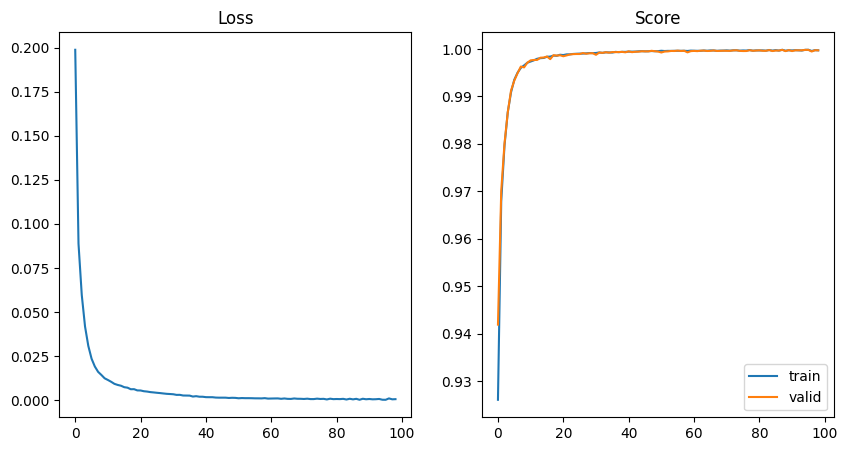

In [ ]:
######################
# 학습 결과 시각화
######################
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# 손실값 시각화
#dict에는 각각 학습손실값 학습 점수 valid점수 들어있음
axes[0].plot(loss_score_dict['train_loss'])
axes[0].set_title('Loss')
# 정확도 시각화
axes[1].plot(loss_score_dict['train_score'], label='train')
axes[1].plot(loss_score_dict['valid_score'], label='valid')
axes[1].set_title('Score')
axes[1].legend()
# 그래프 출력
plt.show()

In [ ]:
######################
# 상수 정의
######################
# 단어(클래스) 갯수
N_CLASS = len(vocab)
# 에폭 수
N_EPOCHS = 100
# 배치 크기
BATCH_SIZE = 1000
# 임베딩 차원 수 (임베딩된 단어의 벡터 차원 수)
EMBEDDING_SIZE = 128
# LSTM 레이어 은닉층의 차원 수
HIDDEN_SIZE = 10
# LSTM 레이어 은닉층 각각의 레이어 갯수
NUM_LAYERS = 3
# LSTM 레이어 양방향 여부
IS_BIDIRECTIONAL = True
# 학습률
LR = 0.001
# 얼리 스토핑 횟수
PATIENCE = 10
# 얼리 스토핑 타겟 스코어
TARGET_SCORE = 0.75
# 쓰레시 홀드(이진분류 기준)
#THRES_HOLD = 0.5
THRES_HOLD = 0.5
# 디바이스 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CPU = 'cpu'

In [ ]:
######################
# 저장된 모델 로드
######################
# 모델 로드
best_model = CompReviewPNModel(n_class=N_CLASS,
                            embedding_size=EMBEDDING_SIZE,
                            hidden_size=HIDDEN_SIZE,
                            num_layers=NUM_LAYERS,
                            is_bidirectional=IS_BIDIRECTIONAL,
                            ).to(DEVICE)
#나중에 다시 집에서 해볼때는 손실점수 파일이름에 적어놓기
best_model.load_state_dict(torch.load('/content/drive/MyDrive/ml/comp_review_model_last.pth')) #라스트 path면 요걸로

<All keys matched successfully>

In [ ]:
review_cont_df.shape

(442290, 2)

In [ ]:
#### 모델 셀렉션용
######################
# 평가
######################
# 데이터셋 생성
test_dataset = ReviewDataset(features, targets)
# 데이터로더 생성
test_dataloader = DataLoader(test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            )
# 평가
atest_result = test_loop(test_dataloader,
                        best_model,
                        DEVICE,
                        )[0] #이거 아니면 바로 [0] 제거
pred_list=test_loop(test_dataloader,
                        best_model,
                        DEVICE,
                        )[1]
#atest_result[0] 은 정확도 점수, [1]은 예측 리스트


In [ ]:
######################
# 평가
######################
# 데이터셋 생성
test_dataset = ReviewDataset(X_test, y_test)
# 데이터로더 생성
test_dataloader = DataLoader(test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            )
# 평가
atest_result = test_loop(test_dataloader,
                        best_model,
                        DEVICE,
                        )[0] #이거 아니면 바로 [0] 제거
pred_list=test_loop(test_dataloader,
                        best_model,
                        DEVICE,
                        )[1]
#atest_result[0] 은 정확도 점수, [1]은 예측 리스트

In [ ]:
######################
# 결과 출력
######################
print(f'Test Score: {atest_result:.4f}') #모델셀렉션용 전체 데이터셋 결과
#print(pred_list)

Test Score: 0.9914


In [ ]:
pred_list[:100]

['P',
 'P',
 'P',
 'P',
 'P',
 'N',
 'N',
 'P',
 'N',
 'N',
 'P',
 'P',
 'P',
 'P',
 'P',
 'N',
 'N',
 'N',
 'N',
 'N',
 'P',
 'P',
 'P',
 'P',
 'P',
 'N',
 'N',
 'N',
 'N',
 'N',
 'P',
 'P',
 'P',
 'P',
 'P',
 'N',
 'P',
 'N',
 'N',
 'N',
 'P',
 'N',
 'P',
 'P',
 'P',
 'P',
 'P',
 'N',
 'N',
 'N',
 'N',
 'N',
 'P',
 'P',
 'P',
 'P',
 'P',
 'N',
 'N',
 'N',
 'N',
 'N',
 'P',
 'P',
 'P',
 'P',
 'P',
 'N',
 'N',
 'N',
 'N',
 'N',
 'P',
 'P',
 'P',
 'P',
 'P',
 'N',
 'N',
 'N',
 'N',
 'N',
 'P',
 'P',
 'N',
 'N',
 'P',
 'P',
 'P',
 'N',
 'N',
 'N',
 'P',
 'P',
 'P',
 'P',
 'N',
 'N',
 'N',
 'N']

In [ ]:
######################
# 평가 2
######################
# 데이터셋 생성
test_dataset = ReviewDataset(features, targets)
# 데이터로더 생성
test_dataloader = DataLoader(test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            )
# 평가
atest_result = test_loop(test_dataloader,
                        best_model,
                        DEVICE,
                        )[0]

In [ ]:
atest_result[1]

In [ ]:
review_cont_df['review_senti_pred']=atest_result[1]

In [ ]:
review_cont_df[:20]

In [ ]:
######################
# 객체 및 변수 생성
######################
#각각 features,targets가 데이터와 라벨들 그리고 vocab이 어휘집
# 데이터 전처리 객체 생성
preprocessing_module = ReviewDataPreprocessing(df_train)
# 데이터 로드
#features, targets = preprocessing_module.load_data()
# vocab 로드
vocab = preprocessing_module.load_vocab()

In [ ]:
#--------------------------------

In [ ]:
with open(DATA_PATH+'/comp_review_test.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)

In [ ]:
test_df = pd.read_csv(DATA_PATH+'/comp_review_test.csv',encoding='utf-8')
test_df

,review_cont,review_senti_orig
0,"온보딩 시스템 부족하고, 개발자들이 빅데이터 도메인에 대한 지식이 부족하다.",N
1,핸드폰요금도 지원되고 자잘한 복지가 굉장히 많은편,P
2,젊은 사람이 많은 듯 합니다.,P
3,다같이 성장하고자하는 문화는 없음.,N
4,말이 플랫폼이지 사실 개별 프로젝트마다 엄청난 휴먼 리소스가 투입되는 노동집약적 비...,N
5,퇴근시간 빠른거 말고는 없네요 그나마 연차 사용 자유로운거..연차도 수당안주니까 자...,P
6,발전 가능성이 의문이다. 대기업 그룹사라서 2-3년 마다 대표가 바뀌기 때문에 그 ...,N
7,자기 원하는 시간 가능,P
8,대한민국에서 그나마 사람을 부품취급하지 않고 대우해주는 회사 오래 다니고 싶네요,P
9,신입 초봉이 낮은 편이고 연봉 인상율도 낮은편이라 주니어 들의 잦은 이직을 한다.,N


In [ ]:
senti_to_int = []
for sent in test_df['review_senti_orig']:
    if sent == 'P':
        sent = 1
        senti_to_int.append(sent)
    else:
        sent = 0
        senti_to_int.append(sent)

test_df['review_senti_orig'] = senti_to_int
test_df

,review_cont,review_senti_orig
0,"[온보딩, 시스템, 부족, 하고, 개발자, 들, 이, 빅데이터, 도메인, 에, 대하...",0
1,"[핸드폰, 요금, 도, 지원, 되, 고, 자잘하, ᆫ, 복지, 가, 굉장히, 많, ...",1
2,"[젊, 은, 사람, 이, 많, 은, 듯, 하, ᆸ니다]",1
3,"[다, 같이, 성장, 하, 고자, 하, 는, 문화, 는, 없, 음]",0
4,"[말, 이, 플랫폼, 이, 지, 사실, 개별, 프로젝트, 마다, 엄청나, ᆫ, 휴먼...",0
5,"[퇴근, 시간, 빠르, ᆫ, 거, 말, 고, 는, 없, 네요, 그나마, 연차, 사용...",1
6,"[발전, 가능, 성, 이, 의문, 이, 다, 대, 기업, 그룹사, 이, 라서, 년,...",0
7,"[자기, 원, 하, 는, 시간, 가능]",1
8,"[대한민국, 에서, 그나마, 사람, 을, 부품, 취급, 하, 지, 않, 고, 대우,...",1
9,"[신입, 초봉, 이, 낮, 은, 편, 이, 고, 연봉, 인상, 율, 도, 낮, 은,...",0


In [ ]:
preprocessing_module = ReviewDataPreprocessing(test_df,'/MiniProj/Models/voab_442290_final2.pkl')#"/MiniProj/Models/voab_442290.pkl") #경로를 원하는 경로로 바꿔주면 됨
# 데이터 로드
features, targets = preprocessing_module.load_data() #보캡 사이즈가 사전학습모델과같으면  성능은 최고봉

set vocab from state_dict
set features
indexing


100%|██████████| 20/20 [00:00<00:00, 14763.48it/s]


padding
83


100%|██████████| 20/20 [00:00<00:00, 129055.51it/s]

set targets


In [ ]:
######################
# 평가 2
######################
# 데이터셋 생성
test_dataset = ReviewDataset(features, targets)
# 데이터로더 생성
test_dataloader = DataLoader(test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            )
# 평가
atest_result = test_loop(test_dataloader,
                        best_model,
                        DEVICE,
                        )[0]

In [ ]:
######################
# 결과 출력
######################
print(f'Test Score: {atest_result:.4f}')
print(pred_list[:10])

Test Score: 1.0000
['P', 'P', 'P', 'P', 'P', 'N', 'N', 'P', 'N', 'N']


In [ ]:
#----------------------------------------------------------